# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

# import itertools
from pickle import dump
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay

import classes.data as data_classes
import configuration as config

/mnt/arkk/llm_detector/classifier


In [2]:
# Instantiate the data class
data = data_classes.TrainTestData(
    training_data = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF,
    testing_data = config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF
)

# Set scoring metrics
scoring_metrics = ['neg_brier_score', 'neg_log_loss', 'accuracy']

## Off-the-shelf XGBoost classifier

In [3]:
# # Cross validate the model
# model = GradientBoostingClassifier()
# kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)

# results = cross_validate(
#     model, data.training.scale_features(), 
#     data.training.encode_labels(), 
#     scoring = scoring_metrics, 
#     cv = kfold, 
#     return_train_score = True
# )


In [4]:
# # Evaluate predictions
# for scoring_metric, dataset in itertools.product(scoring_metrics, ['train', 'test']):

#     metric_mean = round(results[f'{dataset}_{scoring_metric}'].mean(), 2)
#     metric_stdev = round(results[f'{dataset}_{scoring_metric}'].std(), 3)

#     print(f'CV {dataset} {scoring_metric}: {metric_mean:.2f} +/- {metric_stdev:.3f}')


Confusion matrix:
[[16195  1187]
 [ 1619  4346]]

Normalized confusion matrix:


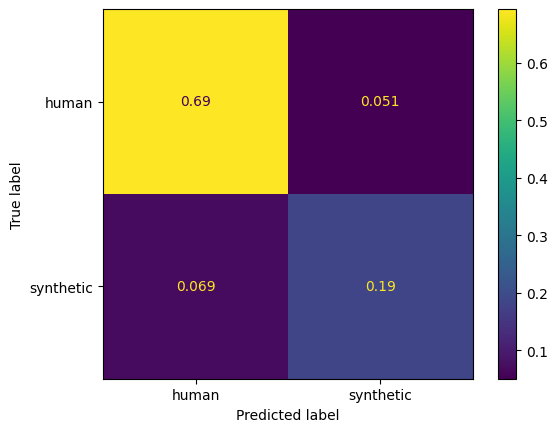

In [5]:
# Fit model on all of the training data
model = GradientBoostingClassifier()
model.fit(data.training.scale_features(), data.training.encode_labels())

# Make predictions for test data
predictions = model.predict(data.testing.scale_features())

# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    data.testing.scale_features(), 
    data.testing.encode_labels(), 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)

In [6]:
# Fit model on all of the training data
model = GradientBoostingClassifier()
model.fit(data.training.scale_features(), data.training.encode_labels())

# Make predictions for test data
predictions = model.predict(data.testing.scale_features())

# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    data.testing.scale_features(), 
    data.testing.encode_labels(), 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)

## Threshold tuned classifier

In [ ]:
# Make probability predictions for test data
probability_predictions = model.predict_proba(data.testing.scale_features())
machine_probability_predictions = probability_predictions[:, 1]

In [ ]:
binned_predictions = {}

for i in range(1, 101, 1):

    binned_predictions[i/100] = {'correct': 0, 'incorrect': 0}

print(binned_predictions)


bins = list(binned_predictions.keys())

for n, i in enumerate(bins):

    for true_label, predicted_label, machine_probability in zip(data.testing.encode_labels(), predictions, machine_probability_predictions):

        if machine_probability > i - 0.1 and machine_probability < i:
            if true_label == predicted_label:
                binned_predictions[i]['correct'] += 1

            elif true_label != predicted_label:
                binned_predictions[i]['incorrect'] += 1

fractions_correct = []

for bin, counts in binned_predictions.items():
    fraction_correct = counts['correct'] / (counts['correct'] + counts['incorrect'])
    fractions_correct.append(fraction_correct)

In [ ]:
import matplotlib.pyplot as plt

plt.title('Fraction correct predictions as\na function of predicted probability')
plt.scatter(bins, fractions_correct)
plt.xlabel('Predicted probability of machine text')
plt.ylabel('Fraction correct predictions')
plt.show()

In [ ]:
from sklearn.model_selection import FixedThresholdClassifier

threshold_tuned_classifier = FixedThresholdClassifier(model, threshold=0.575)
threshold_tuned_classifier.fit(data.training.scale_features(), data.training.encode_labels())

# Make predictions for test data
predictions = threshold_tuned_classifier.predict(data.testing.scale_features())

# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    threshold_tuned_classifier, 
    data.testing.scale_features(), 
    data.testing.encode_labels(), 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)

## Save the model

In [ ]:
output_file = config.XGB_CLASSIFIER

with open(output_file, 'wb') as file:
    dump(model, file, protocol = 5)